# reference exposure time for new BGS reference sky brightness
**problem**: In `new_bgs_reference_sky.ipynb`, I updated the reference BGS sky brightness from the nominal dark time to one that is representative of a typical BGS bright sky. Since the reference sky was updated, the reference exposure time required to achieve L2 redshift success requirements must also be updated.

**solution**: In this notebook I will construct spectral simulations using the new reference BGS sky with different exposure times. Afterwards, I'll run the sims through redrock and find the exposure time that best matches the L2 redshift success requirements.

In [1]:
# first lets install the python package `feasibgs`, a python package for the BGS spectral simulations
!pip install git+https://github.com/desi-bgs/feasiBGS.git --upgrade --user

  Cloning https://github.com/desi-bgs/feasiBGS.git to /tmp/pip-req-build-xxf69h12
  Running command git clone -q https://github.com/desi-bgs/feasiBGS.git /tmp/pip-req-build-xxf69h12
  Created wheel for feasibgs: filename=feasibgs-0.1-py3-none-any.whl size=47422 sha256=eb333fe8ba1d1f810b40716b4dcda57fd966e7d82e796ee4a0e6774dd8f42b4b
  Stored in directory: /tmp/pip-ephem-wheel-cache-6r19dxhj/wheels/f7/d7/9d/824c3b88b5bd8c28b8c576f20984e3cf31a80def7e3deae10a
Successfully built feasibgs
  Attempting uninstall: feasibgs
    Found existing installation: feasibgs 0.1
    Uninstalling feasibgs-0.1:
      Successfully uninstalled feasibgs-0.1


In [2]:
import os, sys
import numpy as np
import fitsio
# --- feasibgs --- 
from feasibgs import util as UT
from feasibgs import cmx as BGS_cmx
from feasibgs import spectral_sims as BGS_spec_sim
from feasibgs import forwardmodel as FM 

In [3]:
# for making pretty plots 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# Load new BGS reference sky 

In [4]:
wave_ref, Isky_ref = np.load('/global/cfs/cdirs/desi/users/chahah/BGS_reference_sky_brightness.20210210.npy')

(0.0, 10.0)

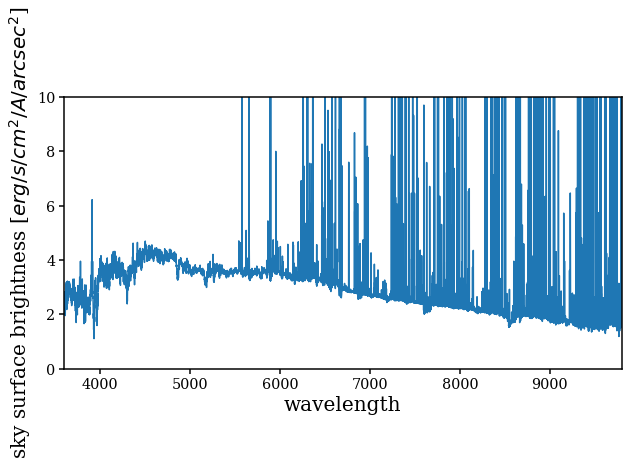

In [5]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(wave_ref, Isky_ref)
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylabel('sky surface brightness [$erg/s/cm^2/A/arcsec^2$]', fontsize=20)
sub.set_ylim(0., 10)

# construct BGS spectral sims

In [6]:
# read in source wavelength, flux, and galaxy properties. 
wave_s, flux_s, prop = BGS_spec_sim.simulated_GAMA_source_spectra(emlines=True) 

In [7]:
# extract true redshift and r-band magnitude for the simulated galaxies
ztrue = prop['zred'] # redshift
r_mag = prop['r_mag'] # Legacy Survey r mag

In [8]:
# run it through the BGS forward model
fdesi = FM.fakeDESIspec()

In [9]:
texps = [240., 260., 280., 300., 360.]

In [10]:
for exptime in texps: 
    fspec = '/global/cfs/cdirs/desi/users/chahah/bgs_spectral_sim.new_bgs_ref_sky.texp%.fs.fits' % exptime
    
    if not os.path.isfile(fspec): 
        bgs = fdesi.simExposure(
            wave_s, 
            flux_s, 
            exptime=exptime, 
            airmass=1.1, 
            Isky=[wave_ref, Isky_ref], 
            filename=fspec
        )
    else: 
        from desispec.io.spectra import read_spectra
        bgs = read_spectra(fspec)        
        print(bgs.ivar['b'][0])

INFO:spectra.py:253:read_spectra: iotime 1.746 sec to read bgs_spectral_sim.new_bgs_ref_sky.texp240s.fits at 2021-02-24T07:29:20.963016
[0.05510315 0.05578206 0.05693059 ... 0.00082289 0.00081245 0.00080604]
INFO:spectra.py:253:read_spectra: iotime 1.734 sec to read bgs_spectral_sim.new_bgs_ref_sky.texp260s.fits at 2021-02-24T07:29:24.090891
[0.06334366 0.06414166 0.06551313 ... 0.00096244 0.0009502  0.00094268]
INFO:spectra.py:253:read_spectra: iotime 1.601 sec to read bgs_spectral_sim.new_bgs_ref_sky.texp280s.fits at 2021-02-24T07:29:26.908827
[0.07198759 0.07291365 0.07452823 ... 0.00111239 0.00109822 0.00108949]
INFO:spectra.py:253:read_spectra: iotime 1.422 sec to read bgs_spectral_sim.new_bgs_ref_sky.texp300s.fits at 2021-02-24T07:29:29.405344
[0.08101111 0.08207397 0.08395159 ... 0.00127263 0.00125639 0.00124637]
INFO:spectra.py:253:read_spectra: iotime 1.508 sec to read bgs_spectral_sim.new_bgs_ref_sky.texp360s.fits at 2021-02-24T07:29:31.891689
[0.11014739 0.11167085 0.1144538

(-5.0, 10.0)

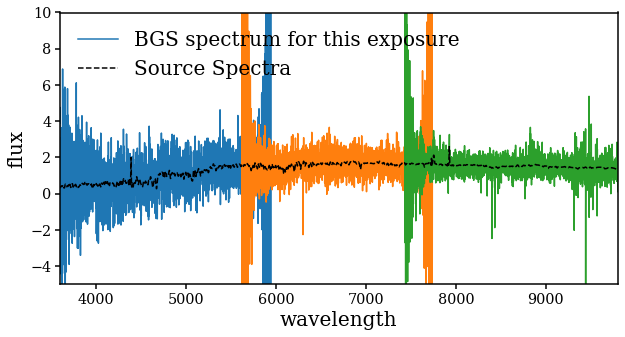

In [11]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for band in ['b', 'r', 'z']: 
    sub.plot(bgs.wave[band], bgs.flux[band][1], label={'b': 'BGS spectrum for this exposure', 'r':None, 'z':None}[band])
sub.plot(wave_s, flux_s[1], c='k', ls='--', label='Source Spectra')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylabel('flux', fontsize=20)
sub.set_ylim(-5, 10)

# run `redrock` on the spectral sims

In [12]:
for exptime in texps: 
    f_spec = '/global/cfs/cdirs/desi/users/chahah/bgs_spectral_sim.new_bgs_ref_sky.texp%.fs.fits' % exptime
    f_rr_h5 = '/global/cfs/cdirs/desi/users/chahah/redrock.bgs_spectral_sim.new_bgs_ref_sky.texp%.fs.h5' % exptime
    f_rr = '/global/cfs/cdirs/desi/users/chahah/redrock.bgs_spectral_sim.new_bgs_ref_sky.texp%.fs.fits' % exptime    
    if os.path.isfile(f_rr): continue 
    print(f_rr)
    !rrdesi -o $f_rr_h5 -z $f_rr $f_spec

# Calculate redshift success
where we define redshift success as
- $|z_{redrock} - z_{true}|/(1+z_{true}) < 0.003$
- ZWARN flag = 0 
- $\Delta \chi^2 > 40$

In [37]:
zsuccesses, rlims = [], [] 
for exptime in texps: 
    # read redrock output
    frr = '/global/cfs/cdirs/desi/users/chahah/redrock.bgs_spectral_sim.new_bgs_ref_sky.texp%.fs.fits' % exptime    
    rr = fitsio.read(frr)

    # redshift success defined as |z_redrock - z_true|/(1+z_true) < 0.003 and ZWARN flag = 0 
    zsuccess = UT.zsuccess(rr['Z'], ztrue, rr['ZWARN'], deltachi2=rr['DELTACHI2'], min_deltachi2=40)
    #zsuccess[r_mag < 18.2] = True # this is to account for the unusual bright z failures, which we think will eventually be ironed out
    zsuccesses.append(zsuccess)
    
    # determine r magnitude limit where we reach 95% redshift completeness
    for _r in np.linspace(17, 20, 31): 
        if (np.sum(zsuccess[r_mag <= _r]) / np.sum(r_mag <= _r)) >= 0.95: rlim = _r
    rlims.append(rlim)

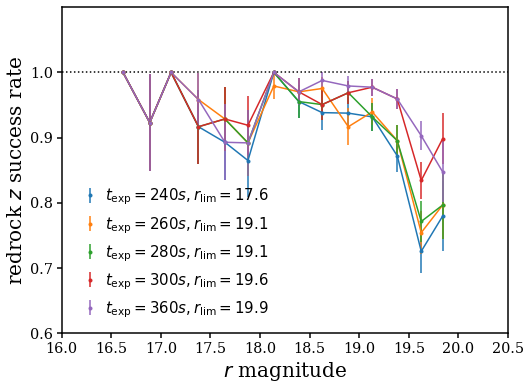

In [38]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.plot([16, 21], [1, 1], c='k', ls=':')

for i, exptime in enumerate(texps):
    # calculate redshift success rate
    wmean, rate, err_rate = UT.zsuccess_rate(r_mag, zsuccesses[i], range=[15, 22], nbins=28, bin_min=10)
    sub.errorbar(wmean, rate, err_rate, fmt='.C%i' % i, label=r'$t_{\rm exp} = %.fs, r_{\rm lim} = %.1f$' % (exptime, rlims[i]))
    sub.plot(wmean, rate, c='C%i' % i)
sub.legend(loc='lower left', handletextpad=0., fontsize=15)
sub.set_xlabel('$r$ magnitude', fontsize=20)
sub.set_xlim(16, 20.5)
sub.set_ylabel('redrock $z$ success rate', fontsize=20)
sub.set_ylim(0.6, 1.1)
sub.set_yticks([0.6, 0.7, 0.8, 0.9, 1.])

Text(0.5, 1.0, '$\\Delta \\chi^2 > 100$')

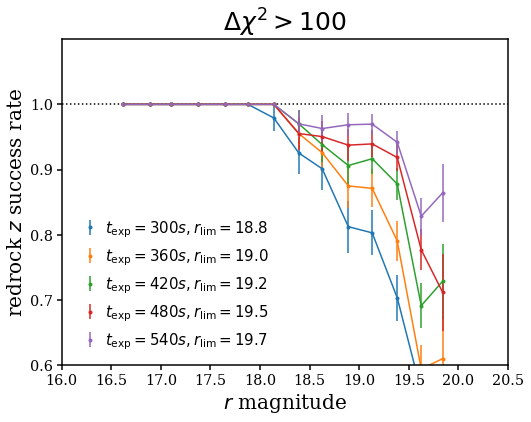

In [39]:
zsuccesses, rlims = [], [] 
for exptime in [300, 360, 420, 480, 540]: 
    # read redrock output
    frr = '/global/cfs/cdirs/desi/users/chahah/redrock.bgs_spectral_sim.new_bgs_ref_sky.texp%.fs.fits' % exptime    
    rr = fitsio.read(frr)

    # redshift success defined as |z_redrock - z_true|/(1+z_true) < 0.003 and ZWARN flag = 0 
    zsuccess = UT.zsuccess(rr['Z'], ztrue, rr['ZWARN'], deltachi2=rr['DELTACHI2'], min_deltachi2=100)
    zsuccess[r_mag < 18.2] = True # this is to account for the unusual bright z failures, which we think will eventually be ironed out
    zsuccesses.append(zsuccess)
    
    # determine r magnitude limit where we reach 95% redshift completeness
    for _r in np.linspace(17, 20, 31): 
        if (np.sum(zsuccess[r_mag <= _r]) / np.sum(r_mag <= _r)) >= 0.95: rlim = _r
    rlims.append(rlim)
    
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.plot([16, 21], [1, 1], c='k', ls=':')

for i, exptime in enumerate([300, 360, 420, 480, 540]):
    # calculate redshift success rate
    wmean, rate, err_rate = UT.zsuccess_rate(r_mag, zsuccesses[i], range=[15, 22], nbins=28, bin_min=10)
    sub.errorbar(wmean, rate, err_rate, fmt='.C%i' % i, label=r'$t_{\rm exp} = %.fs, r_{\rm lim} = %.1f$' % (exptime, rlims[i]))
    sub.plot(wmean, rate, c='C%i' % i)
sub.legend(loc='lower left', handletextpad=0., fontsize=15)
sub.set_xlabel('$r$ magnitude', fontsize=20)
sub.set_xlim(16, 20.5)
sub.set_ylabel('redrock $z$ success rate', fontsize=20)
sub.set_ylim(0.6, 1.1)
sub.set_yticks([0.6, 0.7, 0.8, 0.9, 1.])
sub.set_title('$\Delta \chi^2 > 100$', fontsize=25)

# redshift success beyond $r\sim 19.5$
The GAMA G15-based source spectra is limited past $r > 19.5$, but there are still some objects to test redshift success

Text(0.5, 1.0, 'magnitude distribution of spectral sim')

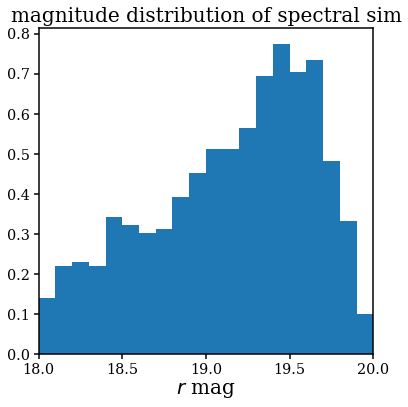

In [40]:
fig = plt.figure(figsize=(6,6,))
sub = fig.add_subplot(111)
sub.hist(r_mag, range=(14, 20), bins=60, density=True)
sub.set_xlabel('$r$ mag', fontsize=20)
sub.set_xlim(18., 20)
sub.set_title('magnitude distribution of spectral sim', fontsize=20)

In [42]:
zsuccesses = []

rlims = [19.5, 19.6, 19.8, 20.]
print('     '+' '.join(['<'+str(_r) for _r in rlims]))
for exptime in [240., 260., 280., 300., 360, 420, 480, 540]: 
    # read redrock output
    frr = '/global/cfs/cdirs/desi/users/chahah/redrock.bgs_spectral_sim.new_bgs_ref_sky.texp%.fs.fits' % exptime    
    rr = fitsio.read(frr)

    # redshift success defined as |z_redrock - z_true|/(1+z_true) < 0.003 and ZWARN flag = 0 
    zsuccess = UT.zsuccess(rr['Z'], ztrue, rr['ZWARN'], deltachi2=rr['DELTACHI2'], min_deltachi2=40)
    #zsuccess[r_mag < 18.2] = True # this is to account for the unusual bright z failures, which we think will eventually be ironed out
    zsuccesses.append(zsuccess)

    # determine redshift success rate for r > 19.5
    zss = [] 
    for _r in rlims: 
        zss.append((np.sum(zsuccess[r_mag <= _r]) / np.sum(r_mag <= _r)))
    print('%is ' % exptime + ' '.join(['%.3f' % zs for zs in zss]))

     <19.5 <19.6 <19.8 <20.0
240s 0.925 0.914 0.886 0.881
260s 0.937 0.925 0.900 0.896
280s 0.938 0.926 0.905 0.900
300s 0.964 0.957 0.938 0.938
360s 0.968 0.967 0.954 0.950
420s 0.976 0.975 0.965 0.963
480s 0.975 0.975 0.966 0.966
540s 0.983 0.983 0.974 0.972


With 300s reference exposure, we can get overall ~95% redshift success out to $r\lesssim19.8$